# CAM (Class Activation Mapping)
**idea**: uses Convolutional Neural Network (CNN) to see which part of an image the model used to make its decision (which parts of the image looked like a dog to the model - ears, paws, etc.)

In [1]:
!pip install tensorflow matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist

In [25]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

In [26]:
# Define CNN model compatible with CAM (GAP + Dense)
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation='softmax')
])

In [27]:
# Compile and train
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=3, validation_split=0.1)

Epoch 1/3
1688/1688 [==============================] - 17s 10ms/step - loss: 1.0908 - accuracy: 0.6539 - val_loss: 0.5429 - val_accuracy: 0.8503
Epoch 2/3
1688/1688 [==============================] - 16s 9ms/step - loss: 0.4978 - accuracy: 0.8530 - val_loss: 0.3537 - val_accuracy: 0.9012
Epoch 3/3
1688/1688 [==============================] - 16s 10ms/step - loss: 0.3775 - accuracy: 0.8882 - val_loss: 0.2994 - val_accuracy: 0.9112


In [28]:
# Get model internals
gap_layer_model = tf.keras.Model(inputs=model.input,
                                 outputs=model.get_layer(index=-2).output)

final_dense = model.layers[-1]
weights = final_dense.get_weights()[0]  # Shape: (num_features, num_classes)

In [29]:
# Pick a test image
i = 0
img = x_test[i:i+1]
true_label = y_test[i]
pred_label = np.argmax(model.predict(img), axis=1)[0]

1/1 [==============================] - 0s 46ms/step


In [30]:
# Forward pass up to GAP layer
feature_maps = gap_layer_model(img)

In [31]:
# Generate CAM
cam = tf.reduce_sum(tf.multiply(feature_maps[0], weights[:, pred_label]), axis=-1).numpy()

In [42]:
# Add batch and channel dimension: (1, H, W, 1)
cam_batch = tf.expand_dims(cam, axis=0)      # (1, H, W)
cam_batch = tf.expand_dims(cam_batch, axis=-1)  # (1, H, W, 1)

In [44]:
# Resize to (28, 28)
cam_resized = tf.image.resize(cam_batch, [28, 28]).numpy().squeeze()
print("Shape after resize and squeeze:", cam_resized.shape)

Shape after resize and squeeze: (28, 28)


In [45]:
#  Normalize and plot
cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())

C:\Users\fbagi\AppData\Local\Temp\ipykernel_34616\2391585011.py:2: RuntimeWarning: invalid value encountered in divide
  cam_resized = (cam_resized - cam_resized.min()) / (cam_resized.max() - cam_resized.min())


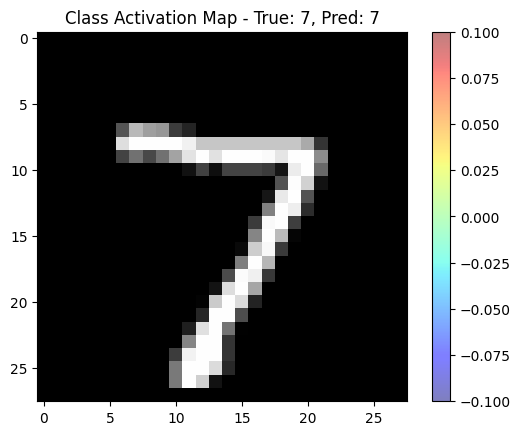

In [46]:
# Visualize
plt.imshow(x_test[i].squeeze(), cmap='gray')
plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title(f'Class Activation Map - True: {true_label}, Pred: {pred_label}')
plt.colorbar()
plt.show()